In [9]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

# Fetch the data

In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
mnist_X_all, mnist_y_all = mnist["data"].to_numpy(), mnist["target"].to_numpy().astype(np.uint8) 
print(mnist_X_all.shape)
print(mnist_y_all.shape)

(70000, 784)
(70000,)


# Helper function to show data

In [12]:
def Show_MNIST_digits(X, **kwargs):
     
    start_index = 0
    randomize = False
    show_labels = False
    rows = 5
    cols = 10
    seed = 42
    y = np.array([])
    
    for key, value in kwargs.items():
        if key == 'randomize':
            randomize = value
        elif key == 'start_index':
            start_index = value
        elif key == 'show_labels':
            show_labels = value
        elif key == 'y':
            y = value
        elif key == 'rows':
            rows = value
        elif key == 'cols':
            cols = value
        elif key == 'seed':
            seed = value
    
    # Fix the seed
    np.random.seed(seed)
    
    # Generate index array
    if randomize:
        indices = np.random.randint(0, high = X.shape[0], size = (rows, cols))
    else:
        indices = np.arange(start_index, start_index + rows * cols).reshape((rows, cols))
    
    # Initialize labels array
    labels = np.zeros((rows, cols), dtype = 'int64')
    
    # Initialize plot dimensions   
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (cols, rows), squeeze = False)
    
    for i in range (0, rows):
        for j in range (0, cols):
            # Get X and y from index
            digit = X[indices[i , j]]
            # reshape to a square image
            digit_image = digit.reshape(28, 28)
            # show image
            ax[i][j].imshow(digit_image, cmap = mpl.cm.binary, interpolation="nearest")
            ax[i][j].axis("off")
            if show_labels:
                labels[i, j] = y[indices[i , j]]
                       
    plt.show()
    if show_labels:
        print(labels)

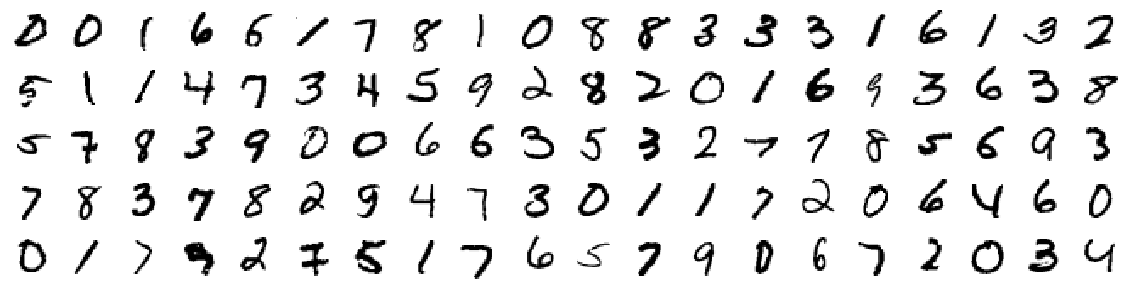

In [13]:
Show_MNIST_digits(mnist_X_all, cols = 20, randomize = True)

# Create Test and training set 

In [5]:
mnist_X_train, mnist_X_test, mnist_y_train, mnist_y_test = mnist_X_all[:60000].copy(), mnist_X_all[60000:].copy(), mnist_y_all[:60000].copy(), mnist_y_all[60000:].copy()

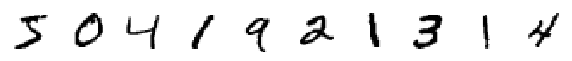

[[5 0 4 1 9 2 1 3 1 4]]


array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [336]:
Show_MNIST_digits(mnist_X_train, y = mnist_y_train, rows = 1, show_labels = True)
mnist_y_train

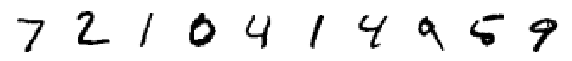

[[7 2 1 0 4 1 4 9 5 9]]


In [179]:
Show_MNIST_digits(mnist_X_test, y = mnist_y_test, rows = 1, show_labels = True)

# Data Augmentation

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
class OneDDataAugmentor(BaseEstimator, TransformerMixin):
    def __init__(self, num_copies = 4):
        self.num_copies = num_copies
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X): 
        return np.concatenate([X] * (self.num_copies + 1), axis=0)

In [354]:
aug = OneDDataAugmentor()
arr = np.array([1,2,3])
aug_arr = aug.fit_transform(arr)
aug_arr

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])

Shift Images

In [8]:
from scipy import ndimage as img

class ShiftDigitsFeatureAugmentor(BaseEstimator, TransformerMixin):
    def __init__(self, pixels = 2):
        self.pixels = pixels
        
    def fit(self, X, y = None):
        return self
    
    def create_shifter_lambda(self, xdir, ydir):
        return lambda x : img.shift(x.reshape(28, 28), [ydir, xdir], cval=0).reshape(x.shape)
    
    def transform(self, X): 
        shifts = [(self.pixels, 0), (-self.pixels, 0), (0 , self.pixels), (0 , -self.pixels)]
        
        X_rets = []
        
        for shift in shifts:
            shift_t = self.create_shifter_lambda(shift[0], shift[1])     
            X_rets.append(np.apply_along_axis(shift_t, axis=1, arr=X))
               
        return np.r_[X_rets[0],X_rets[1],X_rets[2],X_rets[3]]

(20,)


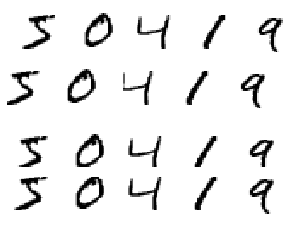

[[5 0 4 1 9]
 [5 0 4 1 9]
 [5 0 4 1 9]
 [5 0 4 1 9]]


In [373]:
aug = OneDDataAugmentor(3)
aug_y = aug.fit_transform(mnist_y_train[0:5])
print(aug_y.shape)

shift_4 = ShiftDigitsFeatureAugmentor(5)
X_shifted = shift_4.fit_transform(mnist_X_train[0:5,:])
Show_MNIST_digits(X_shifted, y = aug_y, rows = 4, cols = 5, show_labels = True)

Rotate Images

In [9]:
class RotateDigitsFeatureAugmentor(BaseEstimator, TransformerMixin):
    def __init__(self, angle = 5, reshape = False):
        self.angle = angle
        self.reshape = reshape
        
    def fit(self, X, y = None):
        return self
    
    def create_rotator_lambda(self, angle):
        return lambda x : img.rotate(x.reshape(28, 28), angle, cval=0, order = 1, reshape = self.reshape).reshape(x.shape)
    
    def transform(self, X): 
        
        rot = self.create_rotator_lambda(self.angle)     
        X_ret_1 = np.apply_along_axis(rot, axis=1, arr=X)
        
        rot = self.create_rotator_lambda(-self.angle)     
        X_ret_2 = np.apply_along_axis(rot, axis=1, arr=X)
               
        return np.r_[X_ret_1, X_ret_2]

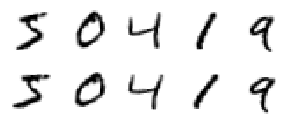

[[5 0 4 1 9]
 [5 0 4 1 9]]


(10, 784)

In [378]:
aug = OneDDataAugmentor(1)
aug_y = aug.fit_transform(mnist_y_train[0:5])

rot = RotateDigitsFeatureAugmentor(5)
X_rotated = rot.fit_transform(mnist_X_train[0:5,:])
Show_MNIST_digits(X_rotated, y = aug_y, rows = 2, cols = 5, show_labels = True)
X_rotated.shape

In [10]:
shifter = ShiftDigitsFeatureAugmentor()
mnist_X_shifted = shifter.fit_transform(mnist_X_train)

rotator = RotateDigitsFeatureAugmentor()
mnist_X_rotated = rotator.fit_transform(mnist_X_train)

mnist_X_augmented = np.r_[mnist_X_train, mnist_X_shifted, mnist_X_rotated]

In [17]:
mnist_X_augmented.shape

(420000, 784)

In [12]:
y_augmentor = OneDDataAugmentor(4 + 2) # 4 shifts,2 rotations

mnist_y_augmented = y_augmentor.fit_transform(mnist_y_train)

In [18]:
mnist_y_augmented.shape

(420000,)

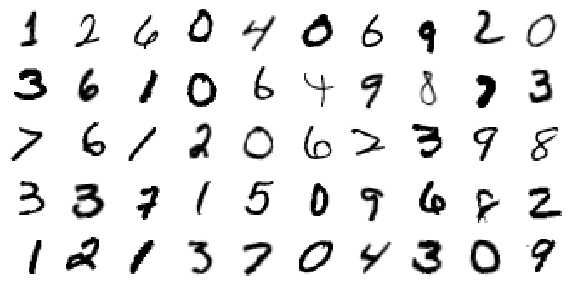

[[1 2 6 0 4 0 6 9 2 0]
 [3 6 1 0 6 4 9 8 7 3]
 [7 6 1 2 0 6 2 3 9 8]
 [3 3 7 1 5 0 9 6 8 2]
 [1 2 1 3 7 0 4 3 0 9]]


In [15]:
Show_MNIST_digits(mnist_X_augmented, y = mnist_y_augmented, randomize = True, show_labels = True, seed = 100)

# Try a test model

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
mnist_X_aug_scaled = scaler.fit_transform(mnist_X_augmented.astype(np.float64))

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [403]:
knn_clf = KNeighborsClassifier(n_jobs = -1)
mnist_X_train_scaled = scaler.fit_transform(mnist_X_train.astype(np.float64))
knn_clf.fit(mnist_X_train_scaled, mnist_y_train)

KNeighborsClassifier(n_jobs=-1)

In [404]:
y_train_pred = knn_clf.predict(mnist_X_train_scaled)

In [418]:
y_train_pred.shape

(60000,)

In [420]:
mnist_X_train.shape

(60000, 784)

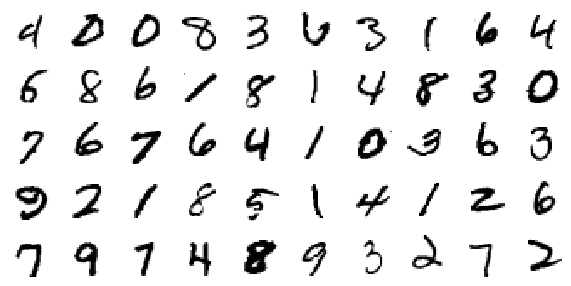

[[4 0 0 8 3 6 3 1 6 4]
 [6 8 6 1 4 1 4 8 3 0]
 [7 6 7 6 4 1 0 3 6 3]
 [9 2 1 8 5 1 4 1 2 6]
 [7 9 7 4 8 9 3 2 7 2]]


In [423]:
Show_MNIST_digits(mnist_X_train, y = y_train_pred, randomize = True, show_labels = True, seed = 42)

In [405]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(mnist_y_train, y_train_pred)
conf_mx

array([[5893,    4,    2,    0,    1,    4,   14,    2,    1,    2],
       [   1, 6721,    7,    0,    0,    0,    1,    9,    1,    2],
       [  24,   36, 5821,   10,    7,    4,    6,   41,    6,    3],
       [   2,   12,   26, 6001,    0,   34,    2,   21,   17,   16],
       [   3,   39,    1,    1, 5724,    0,    6,    5,    2,   61],
       [  13,    5,    3,   35,    5, 5302,   38,    3,    3,   14],
       [  11,    9,    0,    0,    4,   12, 5882,    0,    0,    0],
       [   1,   46,   10,    2,    7,    0,    0, 6165,    0,   34],
       [  15,   59,   10,   40,   20,   51,   14,   11, 5591,   40],
       [  10,    6,    5,   22,   34,    9,    2,   39,    7, 5815]],
      dtype=int64)

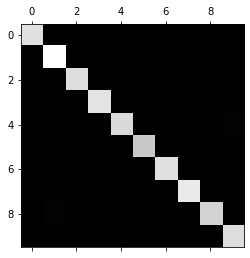

In [406]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [407]:
from sklearn.metrics import accuracy_score
accuracy_score(mnist_y_train, y_train_pred)

0.9819166666666667

In [408]:
from sklearn.metrics import f1_score
f1_score(mnist_y_train, y_train_pred, average='macro')

0.9818602932050764

In [413]:
from sklearn.metrics import roc_auc_score
roc_auc_score(mnist_y_train, knn_clf.predict_proba(mnist_X_train), multi_class = 'ovr')

0.9998786646628612

# Fine Tune

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

prep_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

prep_train_pipeline = Pipeline([
        ('prep_pipeline', prep_pipeline),
        ('classifier', KNeighborsClassifier())
    ])

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'weights': ['uniform'],
        'n_neighbors': randint(low=3, high=10),
    }

knn_clf = KNeighborsClassifier(n_jobs = -1)
rnd_search = RandomizedSearchCV(knn_clf, param_distributions=param_distribs,
                                n_iter=3, cv=2, scoring='accuracy', random_state=42, verbose=10)

rnd_search.fit(mnist_X_aug_scaled, mnist_y_augmented)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 1/3] START n_neighbors=9, weights=uniform..............................
[CV 1/2; 1/3] END ............n_neighbors=9, weights=uniform; total time=22.8min
[CV 2/2; 1/3] START n_neighbors=9, weights=uniform..............................
[CV 2/2; 1/3] END ............n_neighbors=9, weights=uniform; total time=25.1min
[CV 1/2; 2/3] START n_neighbors=6, weights=uniform..............................
[CV 1/2; 2/3] END ............n_neighbors=6, weights=uniform; total time=22.8min
[CV 2/2; 2/3] START n_neighbors=6, weights=uniform..............................
[CV 2/2; 2/3] END ............n_neighbors=6, weights=uniform; total time=25.1min
[CV 1/2; 3/3] START n_neighbors=7, weights=uniform..............................
[CV 1/2; 3/3] END ............n_neighbors=7, weights=uniform; total time=23.0min
[CV 2/2; 3/3] START n_neighbors=7, weights=uniform..............................
[CV 2/2; 3/3] END ............n_neighbors=7, weigh

RandomizedSearchCV(cv=2, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=3,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E180415C88>,
                                        'weights': ['uniform']},
                   random_state=42, scoring='accuracy', verbose=10)

In [24]:
rnd_search.best_params_

{'n_neighbors': 6, 'weights': 'uniform'}

In [25]:
rnd_search.best_estimator_

KNeighborsClassifier(n_jobs=-1, n_neighbors=6)

In [26]:
rnd_search.cv_results_

{'mean_fit_time': array([0.68963385, 0.72356355, 0.68225193]),
 'std_fit_time': array([0.03838921, 0.0074805 , 0.03183794]),
 'mean_score_time': array([1438.48758137, 1437.03035748, 1457.56611729]),
 'std_score_time': array([68.25002658, 67.35779774, 79.66698265]),
 'param_n_neighbors': masked_array(data=[9, 6, 7],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['uniform', 'uniform', 'uniform'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 9, 'weights': 'uniform'},
  {'n_neighbors': 6, 'weights': 'uniform'},
  {'n_neighbors': 7, 'weights': 'uniform'}],
 'split0_test_score': array([0.7903381 , 0.79231429, 0.79282381]),
 'split1_test_score': array([0.85313333, 0.85749048, 0.85667143]),
 'mean_test_score': array([0.82173571, 0.82490238, 0.82474762]),
 'std_test_score': array([0.03139762, 0.0325881 , 0.03192381]),
 'rank_test_score'

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'weights': ['distance'],
        'n_neighbors': randint(low=3, high=10),
    }

knn_clf = KNeighborsClassifier(n_jobs = -1)
rnd_search = RandomizedSearchCV(knn_clf, param_distributions=param_distribs,
                                n_iter=3, cv=2, scoring='accuracy', random_state=42, verbose=10)

rnd_search.fit(mnist_X_aug_scaled, mnist_y_augmented)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 1/3] START n_neighbors=9, weights=distance.............................
[CV 1/2; 1/3] END ...........n_neighbors=9, weights=distance; total time=23.5min
[CV 2/2; 1/3] START n_neighbors=9, weights=distance.............................
[CV 2/2; 1/3] END ...........n_neighbors=9, weights=distance; total time=25.7min
[CV 1/2; 2/3] START n_neighbors=6, weights=distance.............................
[CV 1/2; 2/3] END ...........n_neighbors=6, weights=distance; total time=23.4min
[CV 2/2; 2/3] START n_neighbors=6, weights=distance.............................
[CV 2/2; 2/3] END ...........n_neighbors=6, weights=distance; total time=25.8min
[CV 1/2; 3/3] START n_neighbors=7, weights=distance.............................
[CV 1/2; 3/3] END ...........n_neighbors=7, weights=distance; total time=23.3min
[CV 2/2; 3/3] START n_neighbors=7, weights=distance.............................
[CV 2/2; 3/3] END ...........n_neighbors=7, weight

RandomizedSearchCV(cv=2, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=3,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025514730548>,
                                        'weights': ['distance']},
                   random_state=42, scoring='accuracy', verbose=10)

In [21]:
rnd_search.best_params_

{'n_neighbors': 6, 'weights': 'distance'}

In [22]:
rnd_search.best_estimator_

KNeighborsClassifier(n_jobs=-1, n_neighbors=6, weights='distance')

In [23]:
rnd_search.cv_results_

{'mean_fit_time': array([0.66221452, 0.69066572, 0.68667793]),
 'std_fit_time': array([0.01594377, 0.00949025, 0.00048399]),
 'mean_score_time': array([1475.4665544 , 1474.43632615, 1467.27115822]),
 'std_score_time': array([67.05705476, 71.35510981, 68.27203274]),
 'param_n_neighbors': masked_array(data=[9, 6, 7],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_weights': masked_array(data=['distance', 'distance', 'distance'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 9, 'weights': 'distance'},
  {'n_neighbors': 6, 'weights': 'distance'},
  {'n_neighbors': 7, 'weights': 'distance'}],
 'split0_test_score': array([0.79341429, 0.79863333, 0.7960381 ]),
 'split1_test_score': array([0.85771905, 0.86677619, 0.86148095]),
 'mean_test_score': array([0.82556667, 0.83270476, 0.82875952]),
 'std_test_score': array([0.03215238, 0.03407143, 0.03272143]),
 'rank_test_

# Test on test set

In [26]:
mnist_X_test_prepared = prep_pipeline.fit_transform(mnist_X_test.astype(np.float64))
mnist_y_test_pred = rnd_search.best_estimator_.predict(mnist_X_test_prepared)

In [27]:
from sklearn.metrics import confusion_matrix

conf_mx_test = confusion_matrix(mnist_y_test, mnist_y_test_pred)
conf_mx_test  

array([[ 966,    1,    1,    2,    0,    4,    4,    2,    0,    0],
       [   0, 1130,    4,    0,    1,    0,    0,    0,    0,    0],
       [  11,    3,  973,   11,    1,    1,    0,   23,    6,    3],
       [   1,    1,    5,  966,    1,   14,    0,    9,   12,    1],
       [   0,    8,    5,    1,  937,    0,    7,    5,    0,   19],
       [   3,    1,    2,   17,    3,  851,    6,    1,    3,    5],
       [   4,    7,    0,    0,    2,   10,  933,    0,    2,    0],
       [   1,   29,    9,    1,    3,    1,    0,  962,    1,   21],
       [   3,    3,    4,   11,    6,   20,    1,    5,  917,    4],
       [   3,    8,    5,    7,   14,    5,    0,   26,    3,  938]],
      dtype=int64)

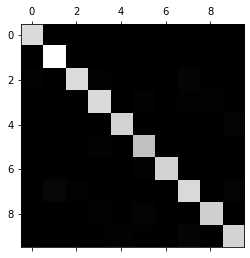

In [28]:
plt.matshow(conf_mx_test, cmap = plt.cm.gray)
plt.show()

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(mnist_y_test, mnist_y_test_pred)

0.9573